Extended Kalman Filter Simulation code written in Python using `jax` library. `jax` is essentially `numpy` with autodiff, and is used for calculating jacobian using `jax.numpy.jacfwd`.

In [2]:
# imports and utility function
import jax
import jax.numpy as jnp
from jax.random import multivariate_normal as jmn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import os
from typing import Callable
from dataclasses import dataclass

os.environ['KMP_DUPLICATE_LIB_OK']='True'

def random(seed=42):
    key = jax.random.PRNGKey(seed)
    while True:
        subkey, key = jax.random.split(key)
        yield subkey
        
key = iter(random())

#### Define `NonLinearModel` Class

Attribute :
- State Transition
    - `f` : model
    - `smean` : gaussian noise mean
    - `covQ` : gaussian noise covariance matrix Q
- Measurement
    - `h` : model
    - `omean` : gaussian noise mean
    - `covR` : gaussian noise covariance matrix R
- `state_0` : initial state

In [3]:
@dataclass
class NonLinearModel:
    
    f: Callable[[jnp.array], jnp.array]
    smean: jnp.array
    covQ: jnp.array
    h: Callable[[jnp.array], jnp.array]
    omean: jnp.array
    covR: jnp.array
    state_0: jnp.array
        
    def observe(self, states):
        v = jmn(next(key), self.omean, self.covR, shape=states.shape[:-1])
        return self.h(states.T).T + v
    
    def nextstate(self, state_curr):
        w = jmn(next(key), self.smean, self.covQ, method='eigh')
        return self.f(state_curr) + w

    def sample(self, n=100):
        states = [self.state_0]
        for _ in trange(n, desc='Sampling'):
            states.append(self.nextstate(states[-1]))
        return jnp.stack(states)

Declare model, run samples and generate observations.

In [8]:
v, dtheta = 100, 3
model = NonLinearModel(
            smean = jnp.zeros((3,)),
            covQ = jnp.diag(jnp.array((0.001, 0.001, 3))),
            omean = jnp.zeros((2,)),
            covR = 0.01*jnp.eye(2),
            f = lambda s: s + jnp.array([v*jnp.cos(s[2]),
                                         v*jnp.sin(s[2]),
                                         dtheta]),
            h = lambda s: jnp.array([jnp.sqrt(s[0]**2+s[1]**2),
                                     jnp.arctan2(s[1], s[0])-s[2]]),
            state_0 = jnp.zeros((3,)),
        )

states = model.sample(n=200)
obsvs = model.observe(states)

Sampling: 100%|██████████| 200/200 [00:00<00:00, 210.88it/s]


#### Define `EFK` Class

In [5]:
def EKF(model: NonLinearModel, obsvs, xhat0=None, covP0=None):
    """Extended Kalman Filter"""
    
    xs = [model.smean if xhat0 is None else xhat0]
    Ps = [model.covQ if covP0 is None else covP0]
    f, Q, h, R = map(model.__getattribute__, ('f', 'covQ', 'h', 'covR'))
    jf, jh = map(jax.jacfwd, (f, h))
    
    x, P = xs[-1], Ps[-1]
    for y in tqdm(obsvs, desc='Running EKF'):
        # pred
        A = jf(x)
        x_, P_ = f(x), A@P@A.T+Q
        
        # corr
        H = jh(x_)
        K = P_@H.T@jnp.linalg.inv(H@P_@H.T+R)
        x, P = x_+K@(y-h(x_)), P_-K@H@P_
        
        xs.append(x), Ps.append(P)

    return jnp.stack(xs), jnp.stack(Ps)

Run Extended Kalman Filter

In [10]:
preds, Ps = EKF(model, obsvs[1:])

Running EKF: 100%|██████████| 200/200 [00:04<00:00, 41.91it/s]


Plot results

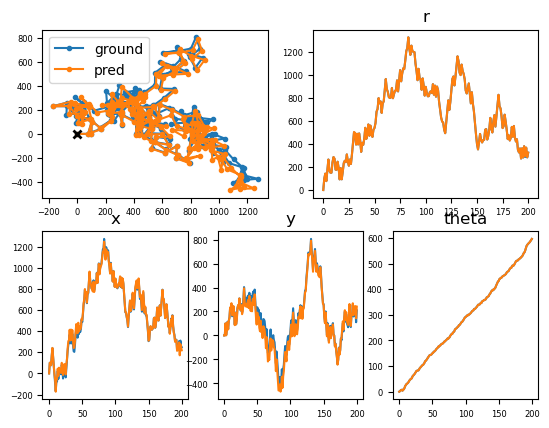

In [13]:
plt.subplot(221),plt.tick_params(labelsize=6)
plt.plot(*states.T[:2], '.-', label='ground')
plt.plot(*preds.T[:2], '.-', label='pred')
plt.plot(*[[0]]*2, 'kx', mew=2)
plt.legend()

plt.subplot(222), plt.title('r'), plt.tick_params(labelsize=6)
*map(plt.plot, (obsvs.T[0], (preds.T[0]**2+ preds.T[1]**2)**0.5)),

titles = 'x', 'y', 'theta'
for n, (title, i, ihat) in enumerate(zip(titles, states.T, preds.T)):
    plt.subplot(234+n), plt.title(title), plt.tick_params(labelsize=6)
    *map(plt.plot, (i, ihat)),
plt.show()